# Lesson 4: Tool Use and Conversational Chess  
工具使用与国际象棋对话

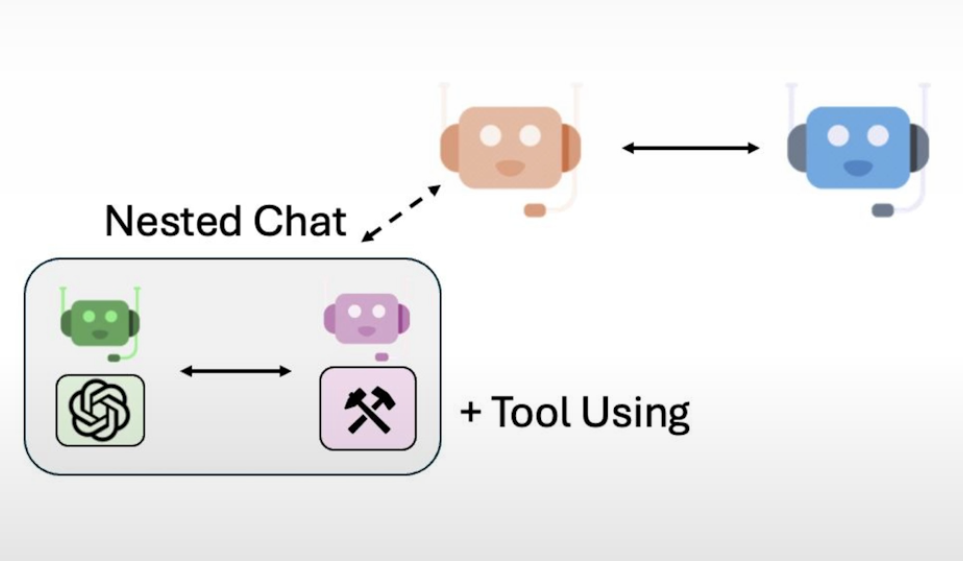

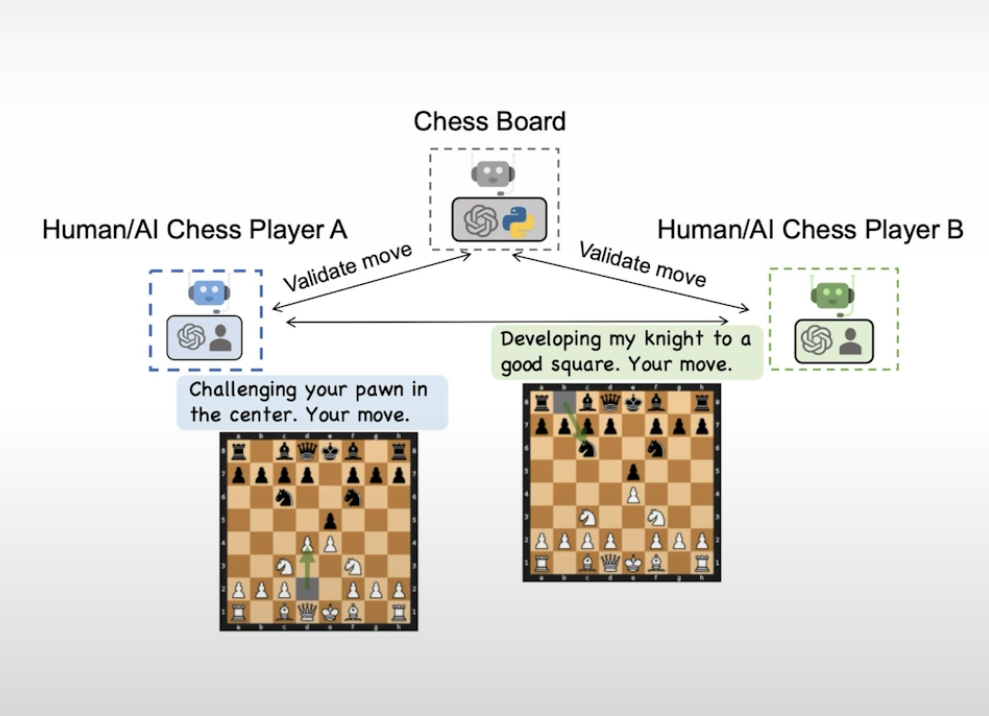

## Setup

In [16]:
llm_config = {"model": "gpt-4-turbo"}

In [17]:
import chess# 可以提供programmer ways to carry over the game
import chess.svg
from typing_extensions import Annotated

## Initialize the chess board  初始化棋盘

In [18]:
board = chess.Board()# 初始化棋盘

In [19]:
made_move = False# 然后使棋盘意识到最近的状态需要一个变量来判定一步棋是否已经走过

## Define the needed tools 定义需要的工具

### 1. Tool for getting legal moves （合法走棋的工具）

In [20]:
def get_legal_moves(
    
) -> Annotated[str, "A list of legal moves in UCI format"]:
    return "Possible moves are: " + ",".join(
        [str(move) for move in board.legal_moves]
    )

In [21]:
get_legal_moves( )

'Possible moves are: g1h3,g1f3,b1c3,b1a3,h2h3,g2g3,f2f3,e2e3,d2d3,c2c3,b2b3,a2a3,h2h4,g2g4,f2f4,e2e4,d2d4,c2c4,b2b4,a2a4'

### 2. Tool for making a move on the board 在棋盘上移动的工具

In [22]:
def make_move(
    move: Annotated[str, "A move in UCI format."]#输入一个move
) -> Annotated[str, "Result of the move."]:# 返回一个move之后的结果
    # 1.根据输入 move 获取一个move 动作
    move = chess.Move.from_uci(move)
    # 2. 在棋盘上move 一下
    board.push_uci(str(move))
    # 3. 更新 是否 已经走棋的标志 made_move
    global made_move
    made_move = True
    
    # 4. Display the board. 展示（创建）棋盘
    display(
        chess.svg.board(
            board,
            arrows=[(move.from_square, move.to_square)],
            fill={move.from_square: "gray"},
            size=200
        )
    )
    # 在返回信息给agent之前，获取关于我们刚刚采取的行动的遗漏（omission）。
    # 5. Get the piece name.
    piece = board.piece_at(move.to_square)# piece from the original point of the move
    # get the symbol of that piece 
    piece_symbol = piece.unicode_symbol()
    # create a piece name
    piece_name = (
        chess.piece_name(piece.piece_type).capitalize()
        if piece_symbol.isupper()
        else chess.piece_name(piece.piece_type)
    )
    # 格式化返回结果
    return f"Moved {piece_name} ({piece_symbol}) from "\
    f"{chess.SQUARE_NAMES[move.from_square]} to "\
    f"{chess.SQUARE_NAMES[move.to_square]}."

## Create agents

You will create the player agents and a board proxy agents for the chess board.  
你将为棋盘创建玩家代理和棋盘代理。

In [23]:
from autogen import ConversableAgent

In [24]:
# Player white agent
# player_white = ConversableAgent(
#     name="Player White",
#     system_message="You are a chess player and you play as white. "
#     "First call get_legal_moves(), to get a list of legal moves. "
#     "Then call make_move(move) to make a move.",
#     llm_config=llm_config,
# )
# Player 白子 agent
player_white = ConversableAgent(
    name="执白棋者",
    system_message="""你是一个围棋高手，你执白棋。
                    1，首先调用 get_legal_moves() 获取一个合法棋步（moves）的列表；
                    2，在列表中选择一个合法棋布（move）后调用  make_move(move) 走一步棋 """,
    llm_config=llm_config,
)

In [25]:
# Player black agent
# player_black = ConversableAgent(
#     name="Player Black",
#     system_message="You are a chess player and you play as black. "
#     "First call get_legal_moves(), to get a list of legal moves. "
#     "Then call make_move(move) to make a move.",
#     llm_config=llm_config,
# )
# Player 黑棋 agent
player_black = ConversableAgent(
    name="执黑棋者",
    system_message="""你是一个围棋高手，你执黑棋。
                    1，首先调用 get_legal_moves() 获取一个合法棋步（moves）的列表；
                    2，在列表中选择一个合法棋布（move）后调用  make_move(move) 走一步棋 """,
    llm_config=llm_config,
)

In [26]:
# 改变走棋状态
def check_made_move(msg):
    global made_move
    if made_move:
        made_move = False
        return True
    else:
        return False


In [27]:
# board_proxy = ConversableAgent(
#     name="Board Proxy",
#     llm_config=False,
#     is_termination_msg=check_made_move,
#     default_auto_reply="Please make a move.",
#     human_input_mode="NEVER",
# )
# 棋盘agent ，检查棋手的走棋直到棋步是正确的,并且切换走棋状态
board_proxy = ConversableAgent(
    name="棋盘裁判代理",
    llm_config=False,
    is_termination_msg=check_made_move,# stopping condition
    default_auto_reply="请走一步棋（move）:",
    human_input_mode="NEVER",
)

## Register the tools to the agents

A tool must be registered for the agent that calls the tool and the agent that executes the tool.  
必须为调用工具的代理和执行工具的代理注册工具。

In [28]:
from autogen import register_function

In [30]:
# 为两个选手都注册工具
for caller in [player_white, player_black]:
    register_function(
        get_legal_moves,# function
        caller=caller,
        executor=board_proxy,
        name="get_legal_moves",
        description="获取合法棋步",
    )
    
    register_function(
        make_move,
        caller=caller,
        executor=board_proxy,# excutor 是board_proxy agent,将会执行tool工具
        name="make_move",
        description="调用工具走一步棋",
    )
# for caller in [player_white, player_black]:
# register_function(
#     get_legal_moves,
#     caller=caller,
#     executor=board_proxy,
#     name="get_legal_moves",
#     description="Get legal moves.",
# )

# register_function(
#     make_move,
#     caller=caller,
#     executor=board_proxy,
#     name="make_move",
#     description="Call this tool to make a move.",
# )

In [31]:
# 检查下执黑棋者的tool配置
player_black.llm_config["tools"]

[{'type': 'function',
  'function': {'description': '获取合法棋步',
   'name': 'get_legal_moves',
   'parameters': {'type': 'object', 'properties': {}, 'required': []}}},
 {'type': 'function',
  'function': {'description': '调用工具走一步棋',
   'name': 'make_move',
   'parameters': {'type': 'object',
    'properties': {'move': {'type': 'string',
      'description': 'A move in UCI format.'}},
    'required': ['move']}}}]

## Register the nested chats

Each player agent will have a nested chat with the board proxy agent to
make moves on the chess board.  
每个玩家代理都将与棋盘代理进行嵌套聊天，以便在棋盘上合法移动。

In [34]:
# 每个棋手走之前都进行嵌入聊天，确保走棋合法
player_white.register_nested_chats(
    trigger=player_black,# 黑棋先走
    chat_queue=[
        {
            "sender": board_proxy,
            "recipient": player_white,
            "summary_method": "last_msg",
        }
    ],
)

player_black.register_nested_chats(
    trigger=player_white,#白棋走了黑棋走
    chat_queue=[
        {
            "sender": board_proxy,
            "recipient": player_black,
            "summary_method": "last_msg",
        }
    ],
)

## Start the Game

The game will start with the first message.

<p style="background-color:#ECECEC; padding:15px; "> <b>Note:</b> In this lesson, you will use GPT 4 for better results. Please note that the lesson has a quota limit. If you want to explore the code in this lesson further, we recommend trying it locally with your own API key.

**Note**: You might get a slightly different moves than what's shown in the video.

执黑棋者 (to 执白棋者):

让我们下棋吧，该你走了！

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
棋盘裁判代理 (to 执白棋者):

让我们下棋吧，该你走了！

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
执白棋者 (to 棋盘裁判代理):

***** Suggested tool call (call_eVjuvXFoZPh6aKcmqrtPKjbT): get_legal_moves *****
Arguments: 
{}
********************************************************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION get_legal_moves...
棋盘裁判代理 (to 执白棋者):

棋盘裁判代理 (to 执白棋者):

***** Response from calling tool (call_eVjuvXFoZPh6aKcmqrtPKjbT) *****
Possible moves are: g1h3,g1f3,b1c3,b1a3,h2h3,g2g3,f2f3,e2e3,d2d3,c2c3,b2b3,a2a3,h2h4,g2g4,f

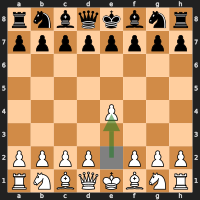

棋盘裁判代理 (to 执白棋者):

棋盘裁判代理 (to 执白棋者):

***** Response from calling tool (call_qzGkd6L5tCxRl80aTdxA0El7) *****
Moved pawn (♙) from e2 to e4.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
执白棋者 (to 棋盘裁判代理):

我已经走了 `e2e4`，把白兵推进到中心。轮到你了！

--------------------------------------------------------------------------------
执白棋者 (to 执黑棋者):

我已经走了 `e2e4`，把白兵推进到中心。轮到你了！

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
棋盘裁判代理 (to 执黑棋者):

我已经走了 `e2e4`，把白兵推进到中心。轮到你了！

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
执黑棋者 (to 棋盘裁判代理):

***** Suggested tool call 

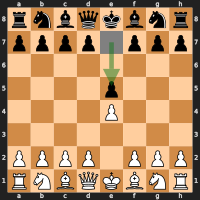

棋盘裁判代理 (to 执黑棋者):

棋盘裁判代理 (to 执黑棋者):

***** Response from calling tool (call_ndv7HKTEwbOX3gIJ7WYwIUtV) *****
Moved pawn (♟) from e7 to e5.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
执黑棋者 (to 棋盘裁判代理):

我已经走了 `e7e5`，以兵对兵的形式回应你的开局。现在轮到你了！

--------------------------------------------------------------------------------
执黑棋者 (to 执白棋者):

我已经走了 `e7e5`，以兵对兵的形式回应你的开局。现在轮到你了！

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
棋盘裁判代理 (to 执白棋者):

我已经走了 `e7e5`，以兵对兵的形式回应你的开局。现在轮到你了！

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
执白棋者 (to 棋盘裁判代理):

*****

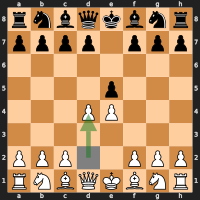

棋盘裁判代理 (to 执白棋者):

棋盘裁判代理 (to 执白棋者):

***** Response from calling tool (call_G1WWGQ3sLBEK9IPfPDrtvp4O) *****
Moved pawn (♙) from d2 to d4.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
执白棋者 (to 棋盘裁判代理):

I've advanced my pawn from d2 to d4 to strengthen my control over the center. Your turn!

--------------------------------------------------------------------------------
执白棋者 (to 执黑棋者):

I've advanced my pawn from d2 to d4 to strengthen my control over the center. Your turn!

--------------------------------------------------------------------------------


In [35]:
# board = chess.Board()

# chat_result = player_black.initiate_chat(
#     player_white,
#     message="Let's play chess! Your move.",
#     max_turns=2,
# )
board = chess.Board()

chat_result = player_black.initiate_chat(
    player_white,
    message="让我们下棋吧，该你走了！",
    max_turns=2,
)

## Adding a fun chitchat to the game! 为游戏添加有趣的闲聊！

In [38]:
# Player white agent
# player_white = ConversableAgent(
#     name="Player White",
#     system_message="You are a chess player and you play as white. "
#     "First call get_legal_moves(), to get a list of legal moves. "
#     "Then call make_move(move) to make a move.",
#     llm_config=llm_config,
# )
# Player 白子 agent
player_white = ConversableAgent(
    name="执白棋者",
    system_message="""你是一个围棋高手，你执白棋。
                    1，首先调用 get_legal_moves() 获取一个合法棋步（moves）的列表；
                    2，在列表中选择一个合法棋布（move）后调用  make_move(move) 走一步棋;
                    3, 走完一步棋后，嘲讽对手增加游戏乐趣""",
    llm_config=llm_config,
)

In [39]:
# Player black agent
# player_black = ConversableAgent(
#     name="Player Black",
#     system_message="You are a chess player and you play as black. "
#     "First call get_legal_moves(), to get a list of legal moves. "
#     "Then call make_move(move) to make a move.",
#     llm_config=llm_config,
# )
# Player 黑棋 agent
player_black = ConversableAgent(
    name="执黑棋者",
    system_message="""你是一个围棋高手，你执黑棋。
                    1，首先调用 get_legal_moves() 获取一个合法棋步（moves）的列表；
                    2，在列表中选择一个合法棋布（move）后调用  make_move(move) 走一步棋;
                    3, 走完一步棋后，嘲讽对手增加游戏乐趣""",
    llm_config=llm_config,
)

In [40]:
for caller in [player_white, player_black]:
    register_function(
        get_legal_moves,
        caller=caller,
        executor=board_proxy,
        name="get_legal_moves",
        description="Get legal moves.",
    )

    register_function(
        make_move,
        caller=caller,
        executor=board_proxy,
        name="make_move",
        description="Call this tool to make a move.",
    )

player_white.register_nested_chats(
    trigger=player_black,
    chat_queue=[
        {
            "sender": board_proxy,
            "recipient": player_white,
            "summary_method": "last_msg",
            "silent": True,
        }
    ],
)

player_black.register_nested_chats(
    trigger=player_white,
    chat_queue=[
        {
            "sender": board_proxy,
            "recipient": player_black,
            "summary_method": "last_msg",
            "silent": True,
        }
    ],
)

执黑棋者 (to 执白棋者):

让我们下棋吧，该你走了！

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION get_legal_moves...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...


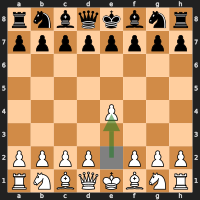


>>>>>>>> USING AUTO REPLY...
执白棋者 (to 执黑棋者):

我已经走了白兵从 e2 到 e4。看起来你也不是那么容易对付，但别忘了，对我来说，这只是轻松的开局！轮到你了，祝好运！

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION get_legal_moves...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...


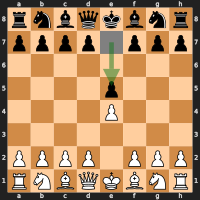


>>>>>>>> USING AUTO REPLY...
执黑棋者 (to 执白棋者):

已经走好了，我的白兵从 e7 走到了 e5。你看，这一步不但回应了你的挑战，同时也为我的棋局开辟了新的可能。继续吧，看看你接下来有什么高招！

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION get_legal_moves...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...


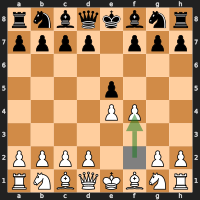


>>>>>>>> USING AUTO REPLY...
执白棋者 (to 执黑棋者):

我刚刚将我的白兵从 f2 走到了 f4。看来这场棋局开始变得有趣了！你的下一步该如何应对呢？别小看了我的小兵，他们可是有潜力冲向皇后的！

--------------------------------------------------------------------------------


In [41]:
board = chess.Board()

chat_result = player_black.initiate_chat(
    player_white,
    message="让我们下棋吧，该你走了！",
    max_turns=2,
)

In [42]:
for caller in [player_white, player_black]:
    register_function(
        get_legal_moves,
        caller=caller,
        executor=board_proxy,
        name="get_legal_moves",
        description="Get legal moves.",
    )

    register_function(
        make_move,
        caller=caller,
        executor=board_proxy,
        name="make_move",
        description="Call this tool to make a move.",
    )

player_white.register_nested_chats(
    trigger=player_black,
    chat_queue=[
        {
            "sender": board_proxy,
            "recipient": player_white,
            "summary_method": "last_msg",
            "silent": False,
        }
    ],
)

player_black.register_nested_chats(
    trigger=player_white,
    chat_queue=[
        {
            "sender": board_proxy,
            "recipient": player_black,
            "summary_method": "last_msg",
            "silent": False,
        }
    ],
)

执黑棋者 (to 执白棋者):

让我们下棋吧，该你走了！

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
棋盘裁判代理 (to 执白棋者):

让我们下棋吧，该你走了！

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
执白棋者 (to 棋盘裁判代理):

***** Suggested tool call (call_97BpIYOujgUkPTbYrz4X0oM2): get_legal_moves *****
Arguments: 
{}
********************************************************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION get_legal_moves...
棋盘裁判代理 (to 执白棋者):

棋盘裁判代理 (to 执白棋者):

***** Response from calling tool (call_97BpIYOujgUkPTbYrz4X0oM2) *****
Possible moves are: g1h3,g1f3,b1c3,b1a3,h2h3,g2g3,f2f3,e2e3,d2d3,c2c3,b2b3,a2a3,h2h4,g2g4,f

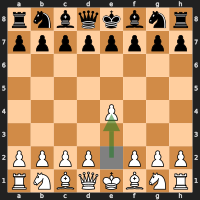

棋盘裁判代理 (to 执白棋者):

棋盘裁判代理 (to 执白棋者):

***** Response from calling tool (call_58yfLiBFwZkhx6xCZdbkGxiC) *****
Moved pawn (♙) from e2 to e4.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
执白棋者 (to 棋盘裁判代理):

我已经走了白兵从 e2 到 e4。看起来你也不是那么容易对付，但别忘了，对我来说，这只是轻松的开局！轮到你了，祝好运！

--------------------------------------------------------------------------------
执白棋者 (to 执黑棋者):

我已经走了白兵从 e2 到 e4。看起来你也不是那么容易对付，但别忘了，对我来说，这只是轻松的开局！轮到你了，祝好运！

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
棋盘裁判代理 (to 执黑棋者):

我已经走了白兵从 e2 到 e4。看起来你也不是那么容易对付，但别忘了，对我来说，这只是轻松的开局！轮到你了，祝好运！

------------------------------------------------------------

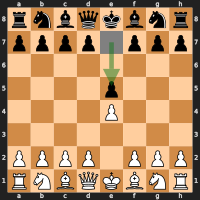

棋盘裁判代理 (to 执黑棋者):

棋盘裁判代理 (to 执黑棋者):

***** Response from calling tool (call_foMxB1s87fVJalv3BzbQWLQJ) *****
Moved pawn (♟) from e7 to e5.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
执黑棋者 (to 棋盘裁判代理):

已经走好了，我的白兵从 e7 走到了 e5。你看，这一步不但回应了你的挑战，同时也为我的棋局开辟了新的可能。继续吧，看看你接下来有什么高招！

--------------------------------------------------------------------------------
执黑棋者 (to 执白棋者):

已经走好了，我的白兵从 e7 走到了 e5。你看，这一步不但回应了你的挑战，同时也为我的棋局开辟了新的可能。继续吧，看看你接下来有什么高招！

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
棋盘裁判代理 (to 执白棋者):

已经走好了，我的白兵从 e7 走到了 e5。你看，这一步不但回应了你的挑战，同时也为我的棋局开辟了新的可能。继续吧，看看你接下来有什么高招！

---------------------------

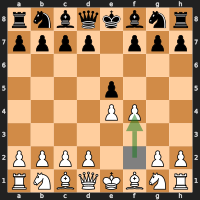

棋盘裁判代理 (to 执白棋者):

棋盘裁判代理 (to 执白棋者):

***** Response from calling tool (call_Q3cdHjpd12zFphO9frOp3HWD) *****
Moved pawn (♙) from f2 to f4.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
执白棋者 (to 棋盘裁判代理):

我刚刚将我的白兵从 f2 走到了 f4。看来这场棋局开始变得有趣了！你的下一步该如何应对呢？别小看了我的小兵，他们可是有潜力冲向皇后的！

--------------------------------------------------------------------------------
执白棋者 (to 执黑棋者):

我刚刚将我的白兵从 f2 走到了 f4。看来这场棋局开始变得有趣了！你的下一步该如何应对呢？别小看了我的小兵，他们可是有潜力冲向皇后的！

--------------------------------------------------------------------------------


In [43]:
board = chess.Board()

chat_result = player_black.initiate_chat(
    player_white,
    message="让我们下棋吧，该你走了！",
    max_turns=2,
)

**Note:** 
To add human input to this game, add **human_input_mode="ALWAYS"** for both player agents.